In [1]:
#pip install torch

In [2]:
#import libraries
import my_utils as mu
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torchvision import datasets,transforms
import numpy as np
import torch
from torch.utils import data # code has also extracted and used from utils file for accuracy, training and evaluation of accuracy
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from IPython import display

# **Task 1. Read Dataset and Dataloaders**

In [3]:
batch_size = 256 # set batch size
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size) #dataloader for training and test data

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



##*Inspect Dataset*:

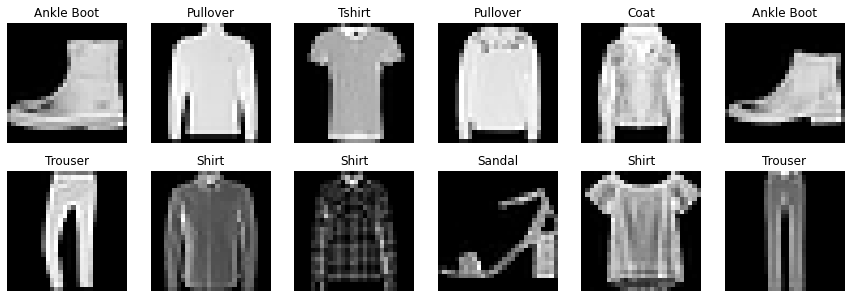

In [4]:
images,labels=next(iter(train_iter))#iterate over the train_dataloader
classes={0:'Tshirt',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle Boot'}
fig=plt.figure(figsize=(15,5))
for i in range(1,13):
    plt.subplot(2,6,i)
    plt.imshow(images[i].view(28,28),cmap='gray')
    plt.axis('off')
    plt.title(str(classes[labels[i].item()]))#show title for each label related to each image in the train_dataloader

# ***Create Pipeline***:

## Architecture Details

### Stem:

  1. Takes as input an image I of size H x W and divides it into Np non-overlapping patches.
  2. Each patch pij has dimensions $${K x K}$$
  3. Each patch is vectorised and then transformed to a feature vector of dimensions: $${d:x_i,j = f(p_i,j)}$$
  4. All features are stored in matrix
  

### Backbone

1. Consists of N Blocks. 
2. The first MLP is:$$g(X^TW_{1})W_{2}$$
3. The next step is: $$(O_{1})\leftarrow O^T_{1}$$
4. The second MLP is $$g(X^TW_{3})W_{4}$$

## **Task 2 Create the Model (Stem and Backbone)**

In [5]:
#torch.nn.Module base class.
class Net(torch.nn.Module): 
    #class constructor that takes number of input feature dimensions and output dimensions.
    def __init__(self,input_num,output_num): # define the layer that the model uses
        
        super(Net, self).__init__() 
        
        self.g_activation_function = torch.nn.ReLU() # set the activation function as RELU.
        self.input_num = input_num # member variable to be used later by member functions in the class.
        self.output_num = output_num # member vairable to be used later by member functions in the class.
        
        #instantiate linear layer objects using the parameters from the class. 
        self.linear_layer_1 = torch.nn.Linear(input_num, input_num) 
        self.linear_layer_2 = torch.nn.Linear(4, 128) # 4 input neurons and 128 output neurons 
        self.linear_layer_3 = torch.nn.Linear(128, 100) # 128 input neurons and 100 output neurons
        self.linear_layer_4 = torch.nn.Linear(196, 128) # 196 input neurons and 128 output neurons
        self.linear_layer_5 = torch.nn.Linear(128, 64) # 128 input neurons and 64 output neurons
        self.linear_layer_6 = torch.nn.Linear(64, output_num) # 64 input neurons and 10 output neurons (representing the 10 classes)
          
    #stem - create patches from each of the 28 X 28 image.
    def patch_data(self,unfolded,input_num):#member function that takes in the batch, unfolds and returns a vector
        B, C, W, H = 256, 1, 28, 28 # batch, channel, height and width. 
        kernel_size = 14 # set kernal size of each patch
        stride = 14 # set stride for each patch (same as the kernal size to ensure non-overlapping patches)
        patches = unfolded.unfold(2, kernel_size, stride).unfold(3, kernel_size, stride) # unfold data across specifed dimensions to produce a patch of 14 x 14 
        patches = patches.contiguous().view(-1, kernel_size*kernel_size, (W // kernel_size)*(H // kernel_size)) # use floor division  such that the last element of the batch can be passed through the neural network. 
        patches = patches.permute(0, 2, 1) # permute to create 256, 4, 196 tensor. 
        return patches # return tensor of patches
    
    #backbone  
    def forward(self, x):
        x = self.patch_data(x, self.input_num)  # patch data (x)  
        x = self.linear_layer_1(x) # pass x to a linear layer 
        XT = torch.transpose(x,1,2) # transpose x 

        #Block One (B1)

        # first multi layer perceptron
        O_1 = self.linear_layer_2(XT) # pass transpose x to linear layer 
        O_1 = self.g_activation_function(O_1) # pass O1 to activation function 
        O_1 = self.linear_layer_3(O_1) # pass O1 to linear layer
        
        O_1_Transposed = torch.transpose(O_1,1,2) # transpose O1

        # second multi layer perceptron
        O_2 = self.linear_layer_4(O_1_Transposed) # pass the transpose O1 to linear layer
        O_2 = self.g_activation_function(O_2) # pass 02 to the activation function
        O_2 = self.linear_layer_5(O_2)#  pass 02 to linear layer
  
        # classifier 
        mean_class = O_2.mean(axis=1) #get the mean 
        mean_class = self.linear_layer_6(mean_class) # pass to final linear layer
        return mean_class # return mean class

In [6]:
#function to store weights and bias
def __init__weights(m):
    if isinstance(m, nn.Linear): # 
        torch.nn.init.xavier_normal_(m.weight) #  xavier
        torch.nn.init.zeros_(m.bias) # add zeros for bias

In [7]:
# initialise the Neural Network
net = Net(196,10) #call the net class, setting input 196 (patched vector dimesion) and output of 10 (representing the 10 classes)
net.apply(__init__weights) # apply the weights to the  net class initialised.



Net(
  (g_activation_function): ReLU()
  (linear_layer_1): Linear(in_features=196, out_features=196, bias=True)
  (linear_layer_2): Linear(in_features=4, out_features=128, bias=True)
  (linear_layer_3): Linear(in_features=128, out_features=100, bias=True)
  (linear_layer_4): Linear(in_features=196, out_features=128, bias=True)
  (linear_layer_5): Linear(in_features=128, out_features=64, bias=True)
  (linear_layer_6): Linear(in_features=64, out_features=10, bias=True)
)

# **Task 3: Create the Loss and Optimizor Function** 

In [8]:
loss = nn.CrossEntropyLoss()# loss function to measure the the quaility of the predicted probability.
#loss = nn.HingeEmbeddingLoss
lr = 0.001 # learning rate 
wd = 0.0001 # weight decay
optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd) # Adam opimizor function. 


# Accuracy

In [9]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# Training:

In [10]:
def train_epoch_ch3(net, train_iter, loss, optimizer):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
#     assert train_loss < 0.5, train_loss
#     assert train_acc <= 1 and train_acc > 0.7, train_acc
#     assert test_acc <= 1 and test_acc > 0.7, test_acc   

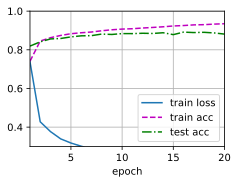

In [11]:
num_epochs = 20 # set epochs
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer) # call training and testing

# Evaluate Accuracy:

In [12]:
print(f' Training Accuracy: {evaluate_accuracy(net, train_iter)}')

 Training Accuracy: 0.9355


In [13]:
print(f' Test Accuracy: {evaluate_accuracy(net, test_iter)}')

 Test Accuracy: 0.8811
